In [1]:
%pip install -q pandas scikit-learn matplotlib

import sys, pandas as pd, sklearn, matplotlib
print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)

Note: you may need to restart the kernel to use updated packages.
Python: 3.13.5
pandas: 2.2.3
scikit-learn: 1.6.1
matplotlib: 3.10.0


In [2]:
import pandas as pd

df = pd.read_csv("dataset.txt", sep=",", header=None, names=["x", "y", "dbh"])

Shape: (960, 3)
   x  y   dbh
0  0  0  1.05
1  0  1  1.43
2  0  2  1.19
3  0  3  1.03
4  0  4  1.36


In [3]:
print("Columns:", df.columns.tolist())
print("\nInfo:")
display(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nBasic stats:")
display(df.describe())

Columns: ['x', 'y', 'dbh']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       960 non-null    int64  
 1   y       960 non-null    int64  
 2   dbh     960 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 22.6 KB


None


Missing values per column:
x      0
y      0
dbh    0
dtype: int64

Basic stats:


,x,y,dbh
count,960.000000,960.000000,960.000000
mean,11.500000,19.500000,2.215781
std,6.925795,11.549413,0.871604
min,0.000000,0.000000,0.380000
25%,5.750000,9.750000,1.600000
50%,11.500000,19.500000,2.090000
75%,17.250000,29.250000,2.752500
max,23.000000,39.000000,6.660000


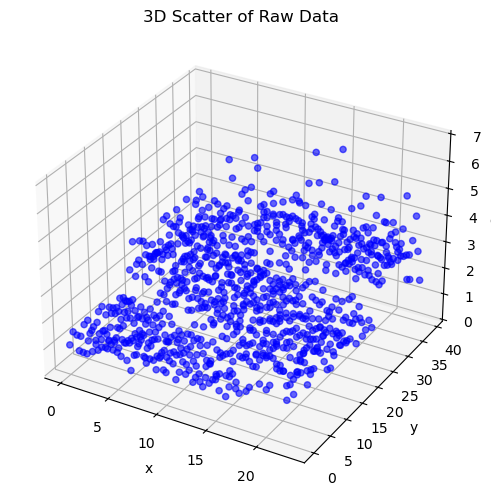

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(df["x"], df["y"], df["dbh"], c="blue", marker="o", alpha=0.6)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("dbh")
plt.title("3D Scatter of Raw Data")
plt.show()



In [5]:
from sklearn.preprocessing import StandardScaler

features = ["x", "y", "dbh"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

import numpy as np
print("Means (should be ~0):", np.mean(X_scaled, axis=0))
print("Standard deviations (should be 1):", np.std(X_scaled, axis=0))

Means (should be ~0): [ 1.18423789e-16  0.00000000e+00 -5.92118946e-17]
Standard deviations (should be 1): [1. 1. 1.]


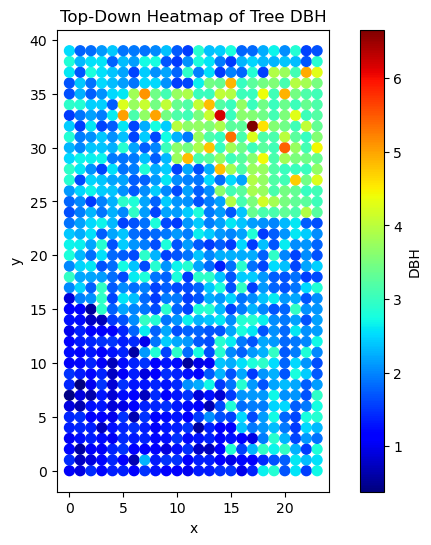

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

plt.scatter(df["x"], df["y"], c=df["dbh"], cmap="jet", s=50)
plt.colorbar(label="DBH")  # adds the color scale
plt.xlabel("x")
plt.ylabel("y")
plt.title("Top-Down Heatmap of Tree DBH")
plt.gca().set_aspect('equal') 
plt.show()


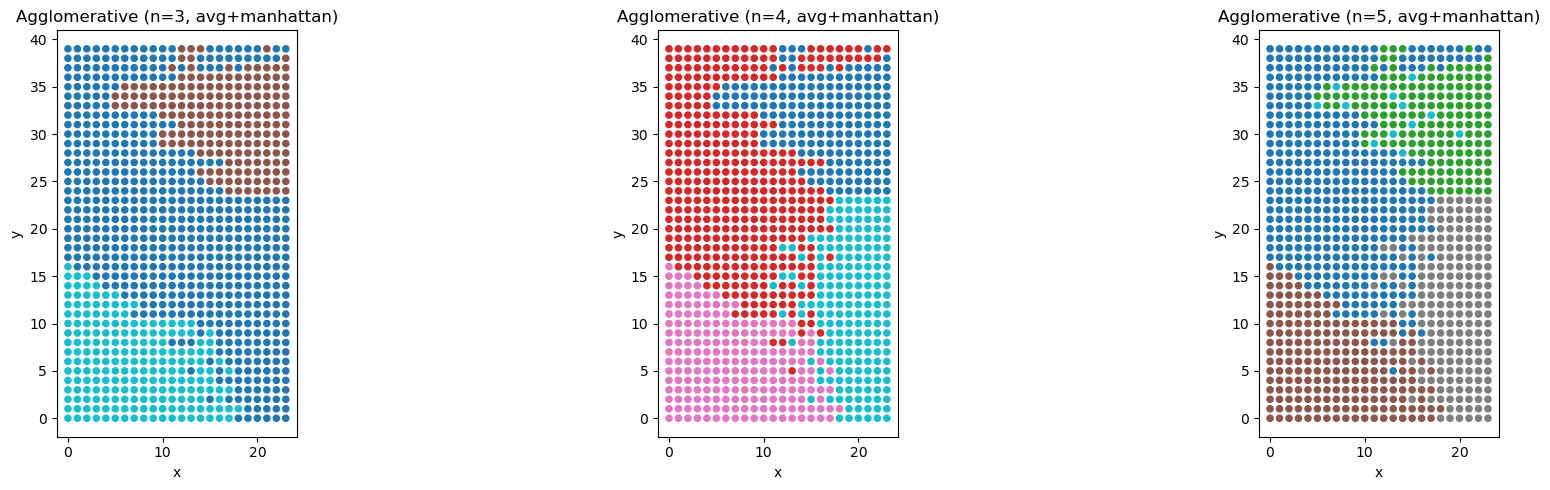

In [10]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

cluster_nums = [3, 4, 5]

fig, axes = plt.subplots(1, len(cluster_nums), figsize=(20, 5))

for i, n_clusters in enumerate(cluster_nums):
    hc = AgglomerativeClustering(
        n_clusters=n_clusters, linkage="average", metric="manhattan"
    )
    labels = hc.fit_predict(X_scaled)

    ax = axes[i]
    ax.scatter(df["x"], df["y"], c=labels, cmap="tab10", s=20)
    ax.set_title(f"Agglomerative (n={n_clusters}, avg+manhattan)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


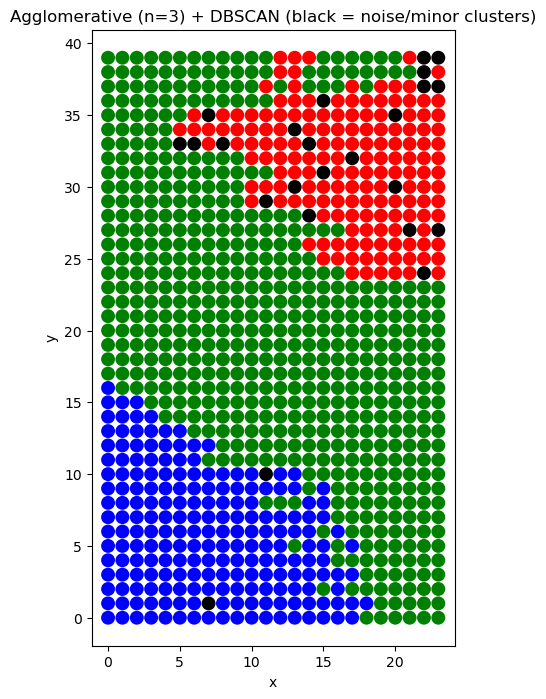

In [11]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

n_clusters = 3
hc = AgglomerativeClustering(n_clusters=n_clusters, linkage="average", metric="manhattan")
labels_hc = hc.fit_predict(X_scaled)
df['hc_label'] = labels_hc

df['local_db'] = None
eps_val = 0.45
min_samples_val = 4

for cluster_id in df['hc_label'].unique():
    mask = df['hc_label'] == cluster_id
    if mask.sum() < 5:
        continue
    X_local = X_scaled[mask.values]
    db_local = DBSCAN(eps=eps_val, min_samples=min_samples_val).fit(X_local)
    local_labels = db_local.labels_
    df.loc[mask, 'local_db'] = [f"{cluster_id}_{lab}" for lab in local_labels]

df['final_label'] = df['local_db']
cluster_labels = pd.factorize(df['final_label'])[0]

counts = np.bincount(cluster_labels[cluster_labels >= 0])
major_clusters = np.argsort(counts)[-3:]
color_map = {major_clusters[0]: "red", major_clusters[1]: "blue", major_clusters[2]: "green"}

colors = []
for lbl in cluster_labels:
    if lbl == -1:
        colors.append("black") 
    elif lbl in major_clusters:
        colors.append(color_map[lbl])
    else:
        colors.append("black") 

plt.figure(figsize=(8, 8))
plt.scatter(df['x'], df['y'], c=colors, marker="o", s=100, edgecolor='none')
plt.title("Agglomerative (n=3) + DBSCAN (black = noise/minor clusters)")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal')
plt.show()
